In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from utils.dataInfo import getTrainData, getTestData, plot_pixel_array, rle2mask, sampleImage
from utils.dataInfo import image, image_grid
from utils.pneumonia_dataset import PneumoniaDataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pydicom
from scipy.sparse import csc_matrix, save_npz, load_npz
import scipy
from networks.network import Thicc_Net
from utils.pneumonia_patches import PneumoniaDataset
from utils.trainer_patches import train_loop

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from tqdm import tqdm

In [2]:
trainPath = 'siim/dicom-images-train/'
testPath = 'siim/dicom-images-test/'
maskPath = 'siim/mask/'

In [3]:
rles_df = pd.read_csv('siim/train-rle.csv')
rles_df.columns = ['ImageId', 'EncodedPixels']

In [4]:
train_df = getTrainData(trainPath, rles_df)

In [5]:
df_pos = pd.DataFrame(train_df.loc[train_df['has_pneumothorax']==True])
df_neg = pd.DataFrame(train_df.loc[train_df['has_pneumothorax']==False])

In [6]:
#20ish % for val 
train_df= pd.concat([df_pos.iloc[:1904], df_neg[:6637]])
val_df = pd.concat([df_pos.iloc[1904:], df_neg[6637:]])

In [7]:
len(train_df), len(val_df)

(8541, 2134)

<Figure size 432x288 with 0 Axes>

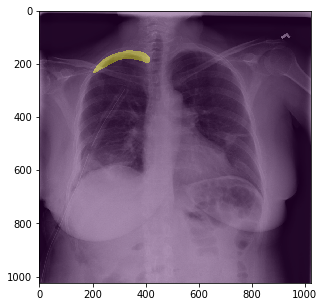

In [8]:
sampleImage(train_df,0, sz=5)

In [9]:
pneumoni_dataset_train = PneumoniaDataset(train_df,
                                      dims=1024,
                                      patchSz=256,
                                      miniBatch=16,
                                      train=True, 
                                      val=False,
                                      transform=True)

pneumoni_dataset_val = PneumoniaDataset(val_df,
                                      dims=1024,
                                      patchSz=256,
                                      miniBatch=16,
                                      train=True, 
                                      val=True,
                                      transform=False)

batch_size_train = 1
batch_size_val = 1

train_loader = torch.utils.data.DataLoader(dataset=pneumoni_dataset_train, 
                                           batch_size=batch_size_train, 
                                           shuffle=False,
                                           drop_last=False)

val_loader = torch.utils.data.DataLoader(dataset=pneumoni_dataset_val, 
                                           batch_size=batch_size_val, 
                                           shuffle=False,
                                           drop_last=False)

In [10]:
# img, mk = next(iter(val_loader))
len(val_loader), len(train_loader)

(2134, 4000)

In [11]:
img, mk = next(iter(train_loader))

In [12]:
img[0][0][0].shape

torch.Size([256, 256])

In [13]:
# for i in range(16):
#     image(img[0][i][0], mk[0][i][0])

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [16]:
model = Thicc_Net([2,2,2,2]) 
if torch.cuda.device_count()>1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)


state_dict = torch.load('exp/epoch1_2_256/best.pth')#path_to_experiment+saved_name)
model.load_state_dict(state_dict)
model.to(device)

Thicc_Net(
  (block1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(1, 1), stride=(1, 1))
    (1): ResidualBlock(
      (block): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.2)
        (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): ReLU()
        (7): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (9): ReLU()
      )
    )
  )
  (pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
    (1): ResidualBlock(
      (block): Sequential(
        (0): 

In [17]:
save_bst = 'exp/epoch1_3_256/best.pth'
save_last = 'exp/epoch1_3_256/last.pth'

In [18]:
criterion = nn.BCEWithLogitsLoss()
learning_rate = 0.001

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer, 
                                                 milestones=[500], gamma=0.1)

In [ ]:
hist = train_loop(train_loader,val_loader,model,optimizer,scheduler,criterion,
                 save_bst,save_last,2000)

EPOCH:  1


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [ ]:
model = Thicc_Net([2,2,2,2]) 

if torch.cuda.device_count()>1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)
model.to(device)

# save_bst = 'exp/exp3_512/best.pth'
state_dict = torch.load(save_bst)#path_to_experiment+saved_name)
model.load_state_dict(state_dict)

In [ ]:
len(val_loader)

In [20]:
imgv, mkv  =  next(iter(val_loader))

In [21]:
imgv = imgv.squeeze(dim=0)
mkv = mkv.squeeze(dim=0)
imgv.shape, mkv.shape

(torch.Size([16, 1, 256, 256]), torch.Size([16, 1, 256, 256]))

In [22]:
model.eval()
res = []
count =0
# for i in range(16):


img = Variable(imgv.float()).to(device)
outputs = model(img)

size = outputs.shape[0]

if size==16:
    for i in range(16):
        res.append(F.sigmoid(outputs)[i].squeeze().data.cpu().numpy()) 
if size==2:
    for i in range(2):
        res.append(F.sigmoid(outputs)[i].squeeze().data.cpu().numpy()) 


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [23]:
res[0].shape

(256, 256)

In [24]:
res[2].max()

0.7588288

<Figure size 432x288 with 0 Axes>

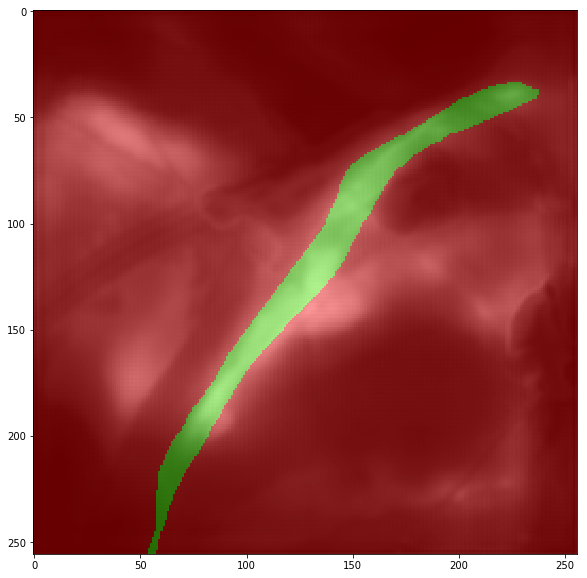

<Figure size 432x288 with 0 Axes>

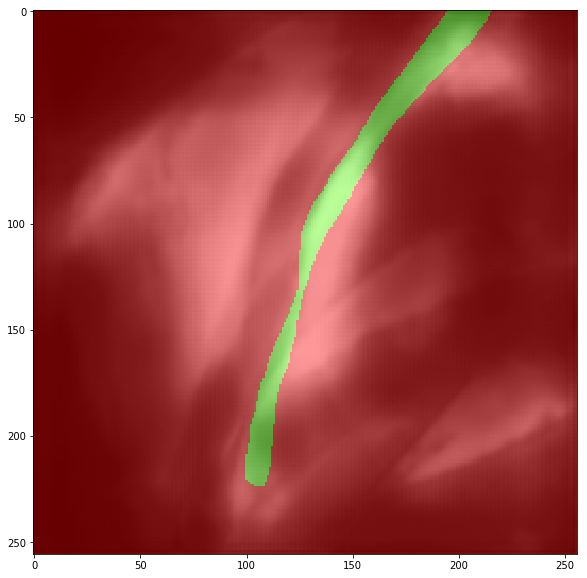

<Figure size 432x288 with 0 Axes>

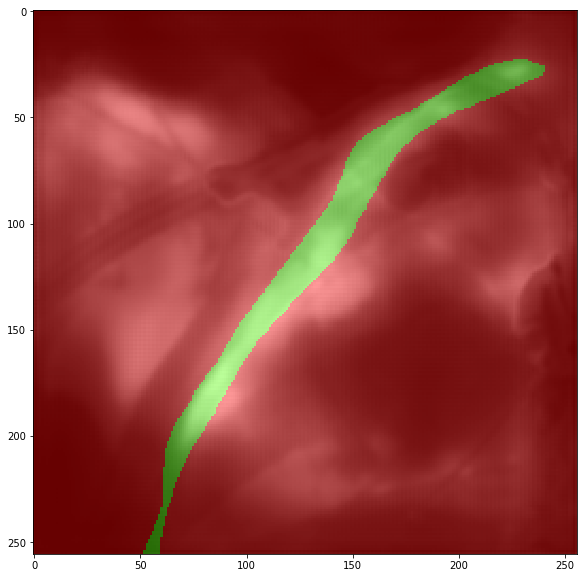

<Figure size 432x288 with 0 Axes>

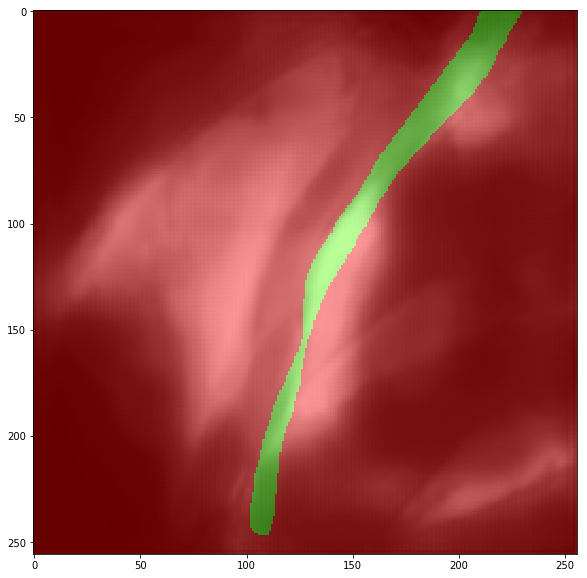

<Figure size 432x288 with 0 Axes>

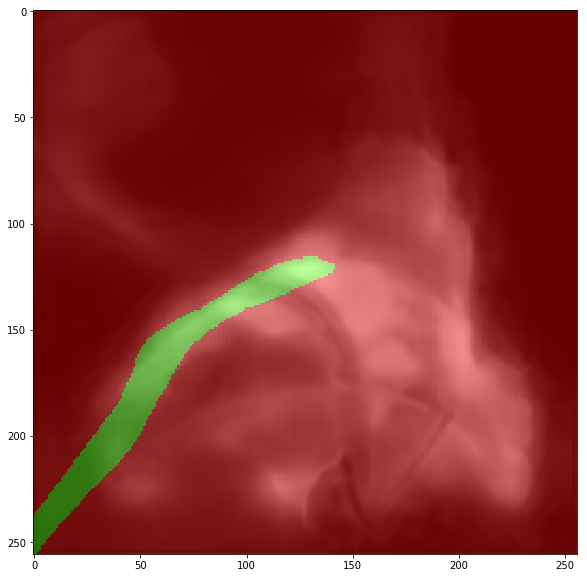

<Figure size 432x288 with 0 Axes>

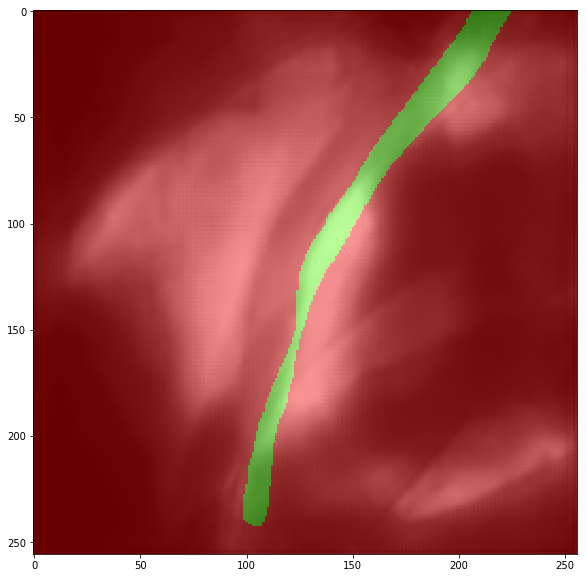

<Figure size 432x288 with 0 Axes>

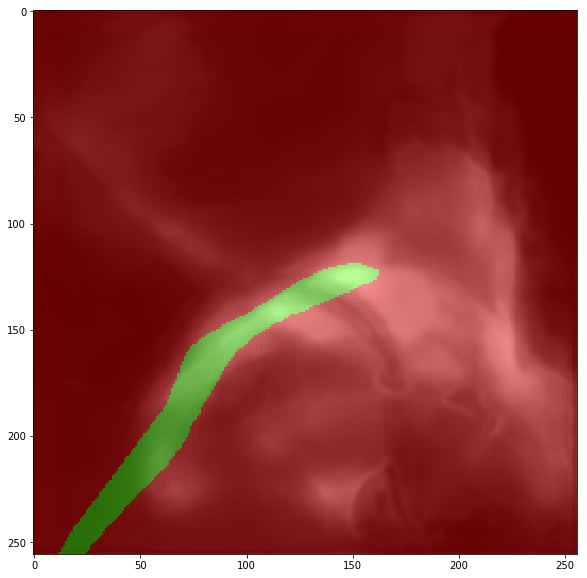

<Figure size 432x288 with 0 Axes>

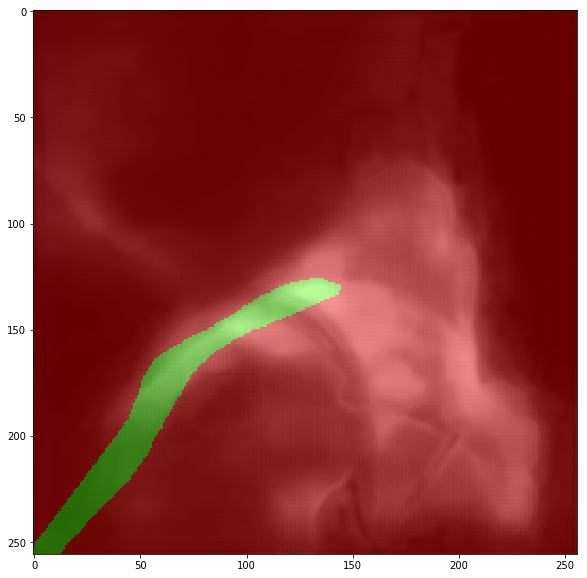

<Figure size 432x288 with 0 Axes>

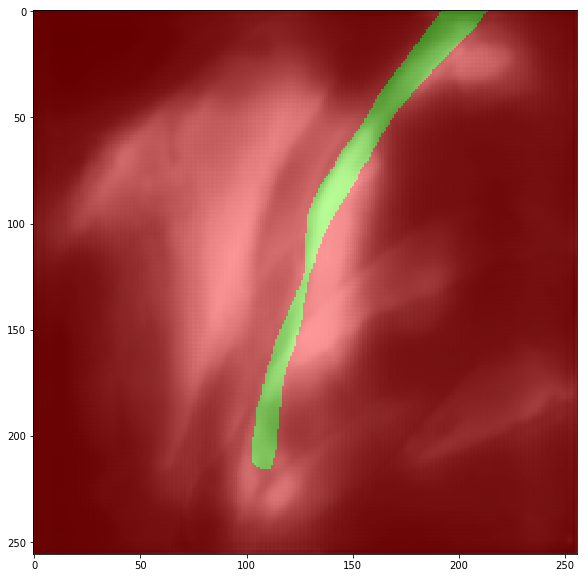

<Figure size 432x288 with 0 Axes>

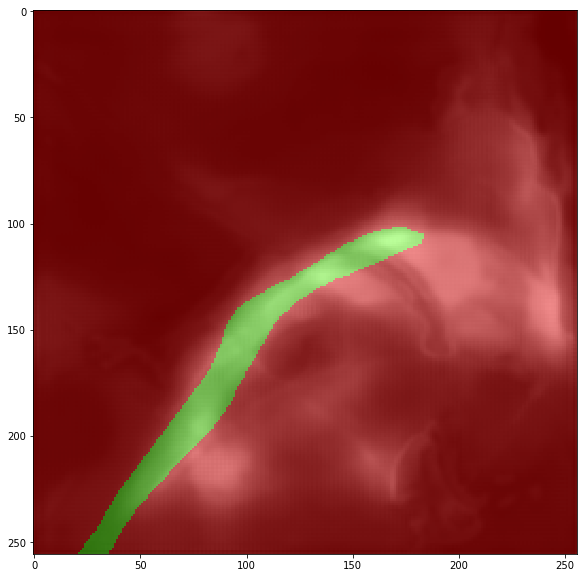

<Figure size 432x288 with 0 Axes>

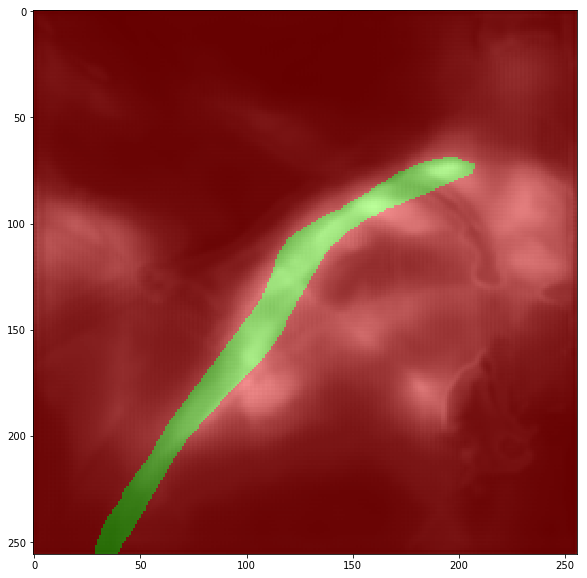

<Figure size 432x288 with 0 Axes>

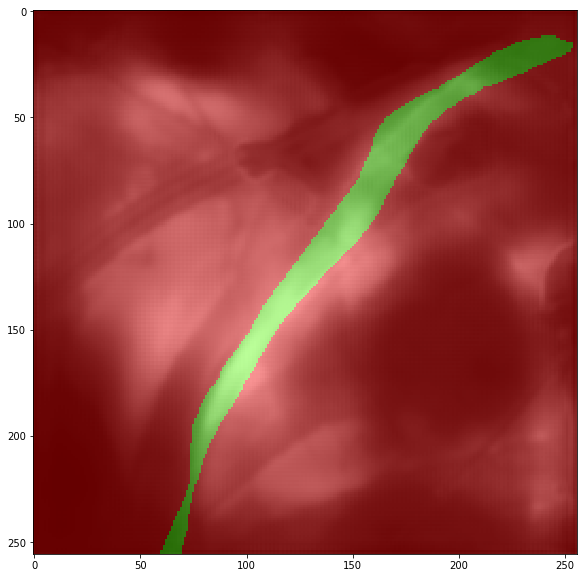

<Figure size 432x288 with 0 Axes>

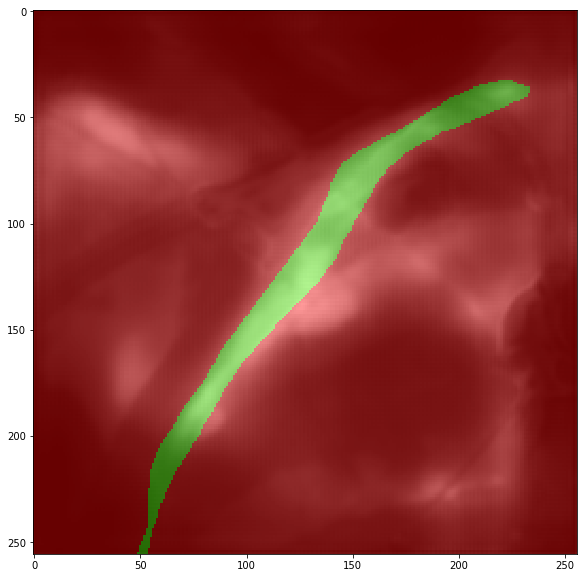

<Figure size 432x288 with 0 Axes>

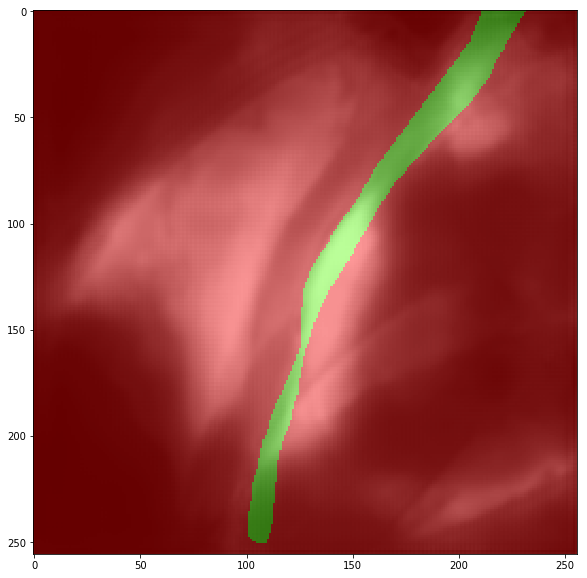

<Figure size 432x288 with 0 Axes>

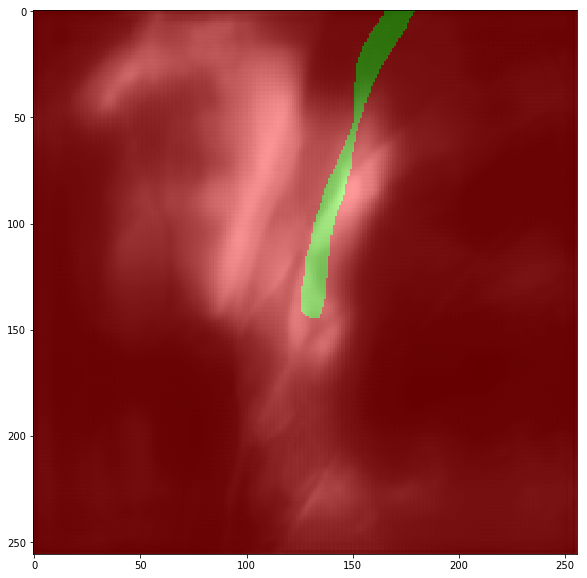

<Figure size 432x288 with 0 Axes>

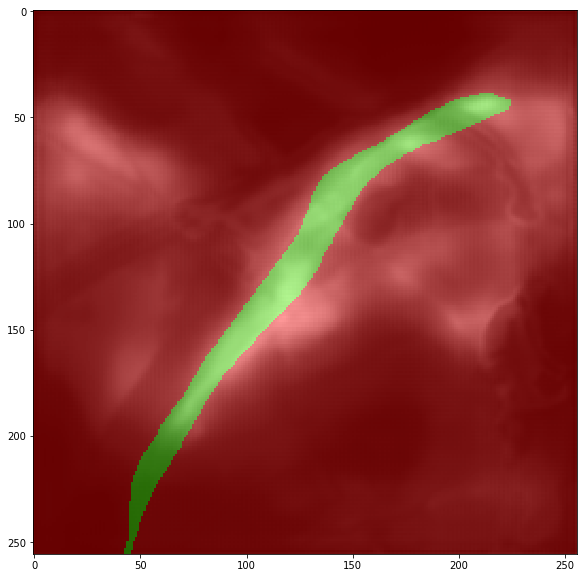

In [26]:
for i in range(16):
    image(res[i], mkv[i][0])

In [48]:
res[15].max()

0.077267885

<Figure size 432x288 with 0 Axes>

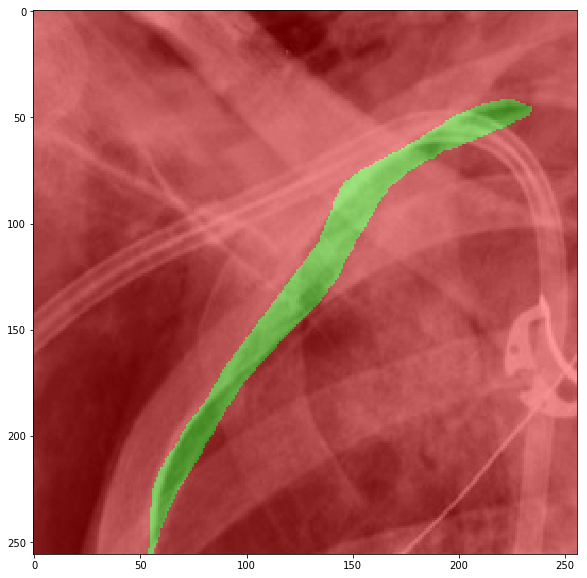

<Figure size 432x288 with 0 Axes>

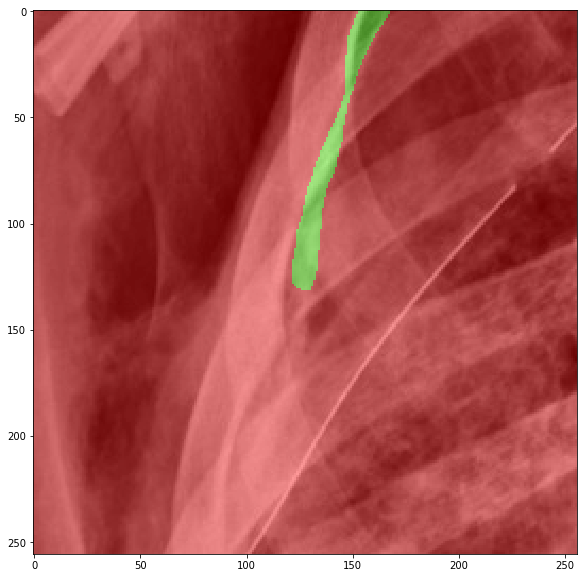

<Figure size 432x288 with 0 Axes>

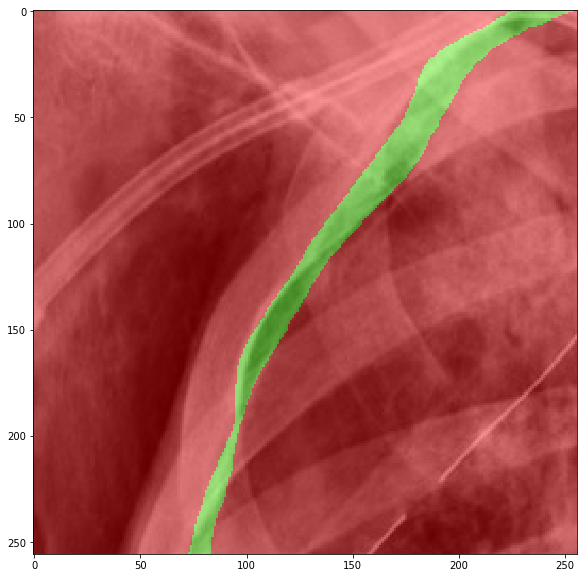

<Figure size 432x288 with 0 Axes>

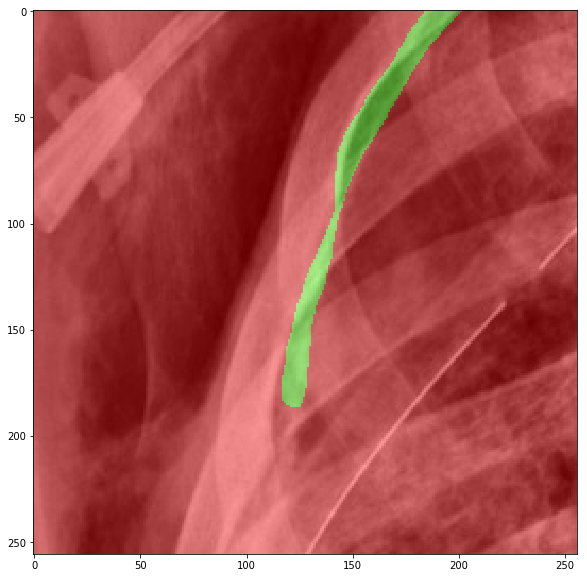

<Figure size 432x288 with 0 Axes>

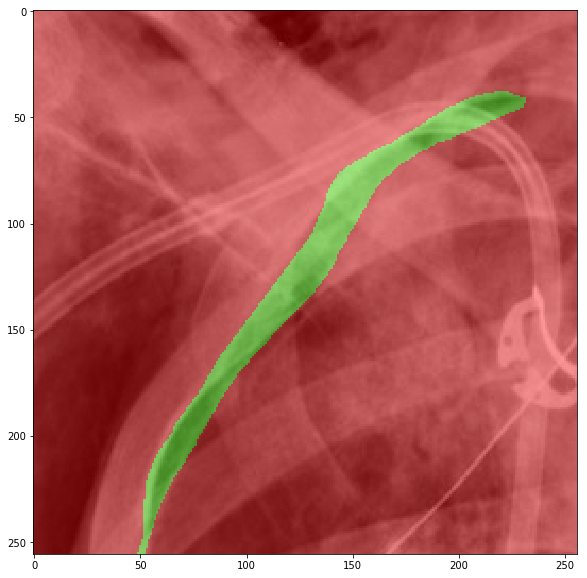

<Figure size 432x288 with 0 Axes>

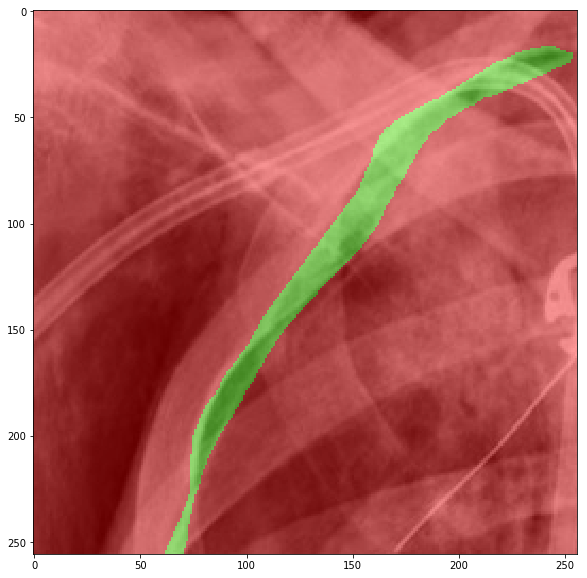

<Figure size 432x288 with 0 Axes>

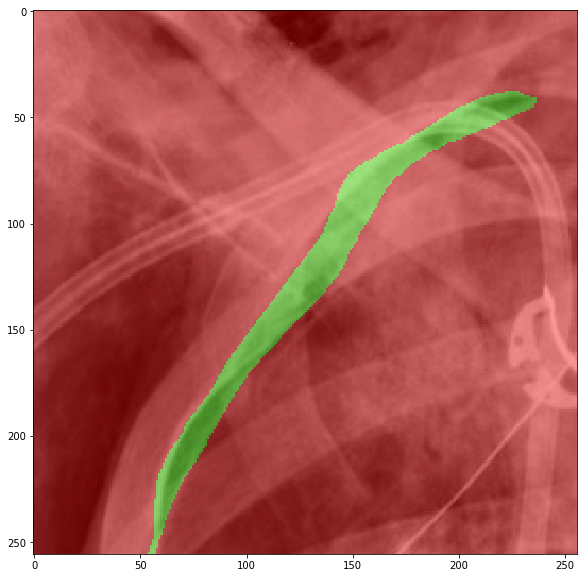

<Figure size 432x288 with 0 Axes>

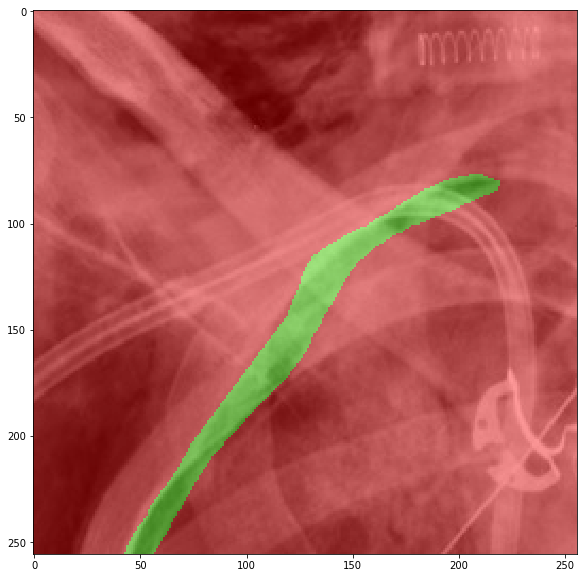

<Figure size 432x288 with 0 Axes>

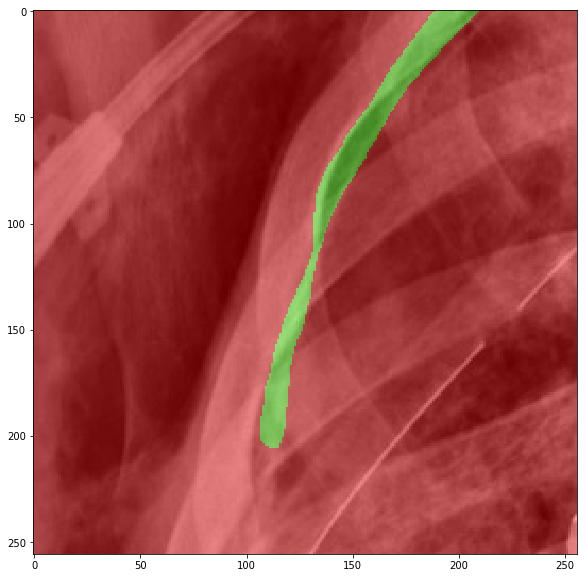

<Figure size 432x288 with 0 Axes>

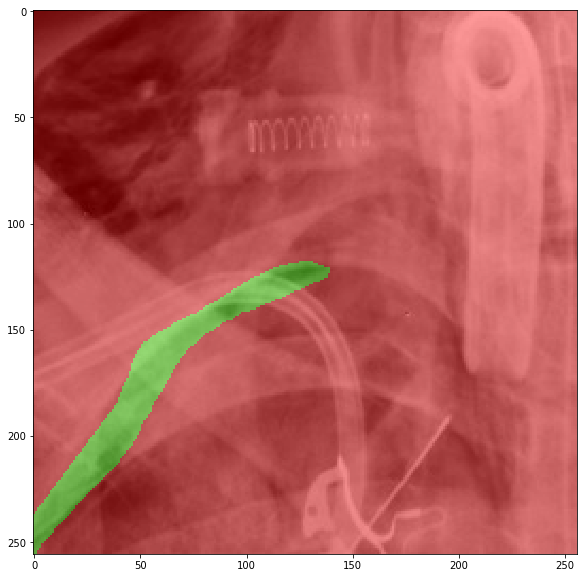

<Figure size 432x288 with 0 Axes>

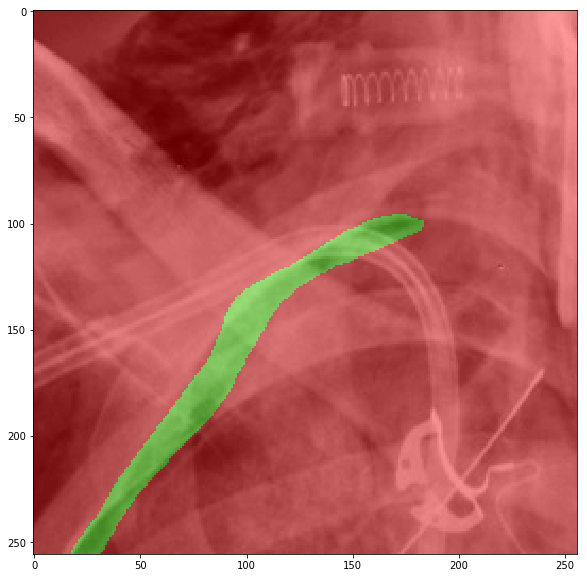

<Figure size 432x288 with 0 Axes>

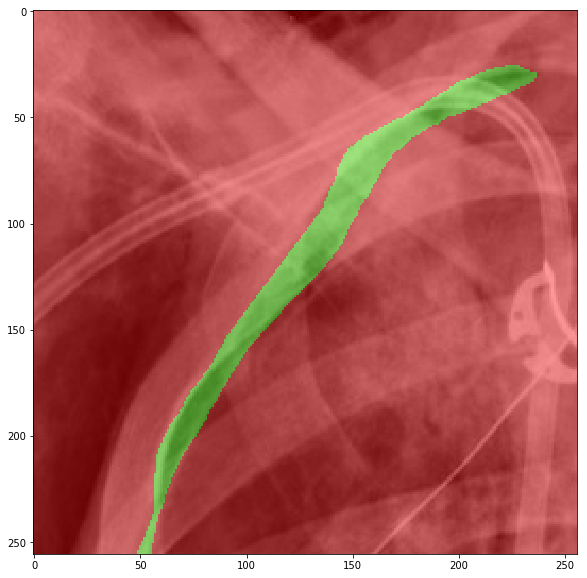

<Figure size 432x288 with 0 Axes>

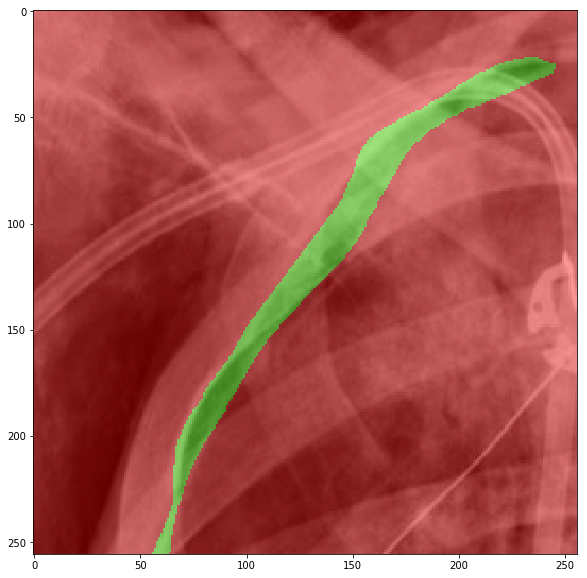

<Figure size 432x288 with 0 Axes>

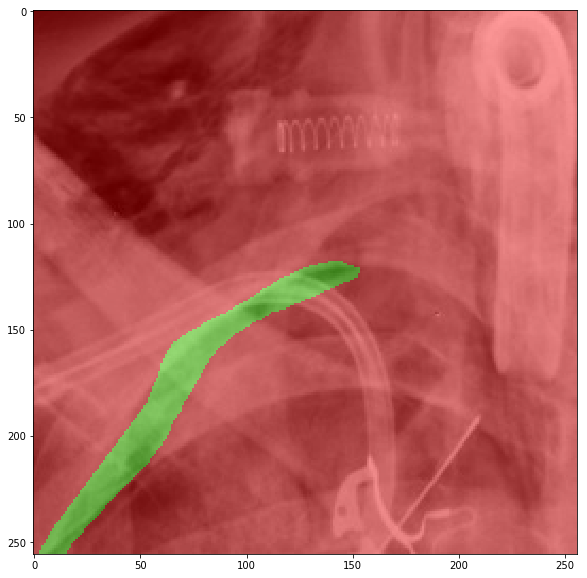

<Figure size 432x288 with 0 Axes>

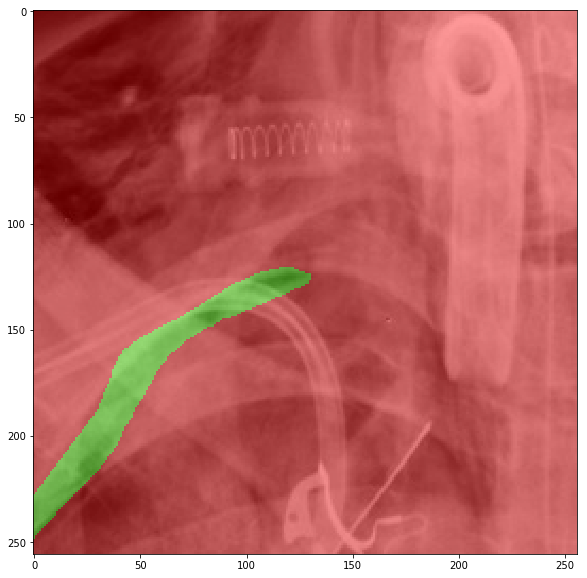

<Figure size 432x288 with 0 Axes>

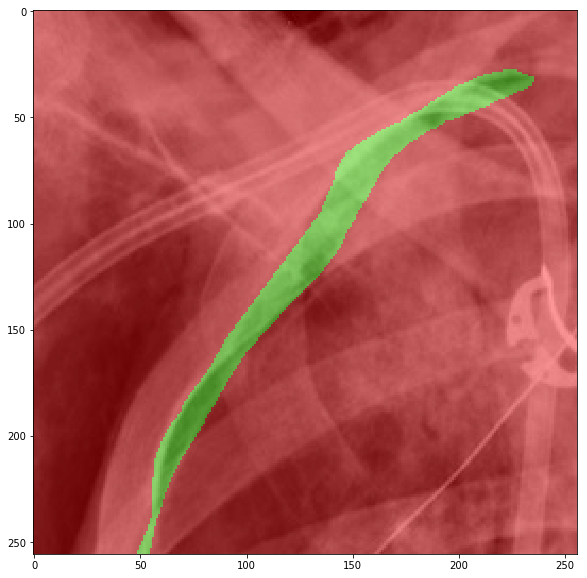

In [37]:
for i in range(16):
    image(imgv[i][0], mkv[i][0])